# Get and Format Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

In [2]:
TRAIN_PATH = 'train.csv'
data = pd.read_csv(TRAIN_PATH)

def format_numeric_no_nan(data):
    df = data.copy()
    sufrv = df['Survived']
    df = df.loc[:, ~df.columns.isin(['Survived','Name','Cabin','Embarked'])]
    # Making numeric
    df['Sex'] = df['Sex'].apply(lambda x: 0 if x=='female' else 1)
    #ignoring non numeric tickets for now
    df['Ticket'] = df['Ticket'].apply(lambda x: float(x) if x.isdigit() else np.nan)
    #fill all missing data using mean
    df = df.fillna(df.mean())
    return df,sufrv

x, y = format_numeric_no_nan(data) 

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.1, random_state=42)

from sklearn.model_selection import ShuffleSplit


rs = ShuffleSplit(n_splits=1000000, test_size=0.1, random_state=42)
rs.get_n_splits(x_train)
it = rs.split(x_train)
def next_split(it):
    train_id, test_id = next(it)
    train_id = x_train.index[train_id]
    test_id = x_train.index[test_id]
    return x_train.loc[train_id],x_train.loc[test_id], y_train.loc[train_id],  y_train.loc[test_id]

# Basic Random Forest Classifier

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from itertools import chain


#There are too few trees to use OOB
n_range1 = list(range(2,17))
#These are fine for oob
n_range2 = list(range(17,70,2))

n_range = list(chain(n_range1,n_range2))
roc = np.zeros(len(n_range))
acc = np.zeros(len(n_range))

import warnings
warnings.filterwarnings("ignore", category=Warning)

for i, n in enumerate(n_range):
    clsfr = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    clsfr.fit(x_train, y_train)
    acc[i] = clsfr.oob_score_
    pred_train = np.argmax(clsfr.oob_decision_function_,axis=1)
    roc_auc = roc_auc_score(y_train, pred_train)
    roc[i] = roc_auc

warnings.filterwarnings("default", category=Warning)

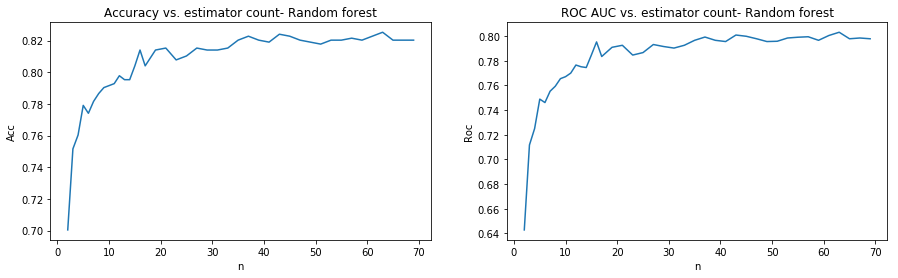

In [35]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(n_range,acc)
plt.title("Accuracy vs. estimator count- Random forest")
plt.xlabel('n')
plt.ylabel('Acc');
plt.subplot(122)
plt.plot(n_range,roc)
plt.title("ROC AUC vs. estimator count- Random forest")
plt.xlabel('n')
plt.ylabel('Roc');
plt.savefig('rf_roc_and_acc')

In [4]:
best = max(enumerate(acc), key=lambda x:x[1])
print('Best is',n_range[best[0]],'with oob accuracy of',best[1])
clsfr_random_forest = RandomForestClassifier(n_estimators=n_range[best[0]], oob_score=True, random_state=42)
clsfr_random_forest.fit(x_train, y_train)
print('validation accuracy:',clsfr_random_forest.score(x_valid, y_valid))
rf_desc = str(n_range[best[0]])+' trees'

Best is 63 with oob accuracy of 0.8252184769038702
validation accuracy: 0.8222222222222222


# Reviewing errors 

In [5]:
pred = clsfr.predict(x_valid)
errs = x_valid[pred != y_valid]
errs['Survived'] = y_valid[pred != y_valid]

/home/guy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
print(y_train.value_counts(normalize=True))
errs.Survived.value_counts()

0    0.617978
1    0.382022
Name: Survived, dtype: float64


1    8
0    8
Name: Survived, dtype: int64

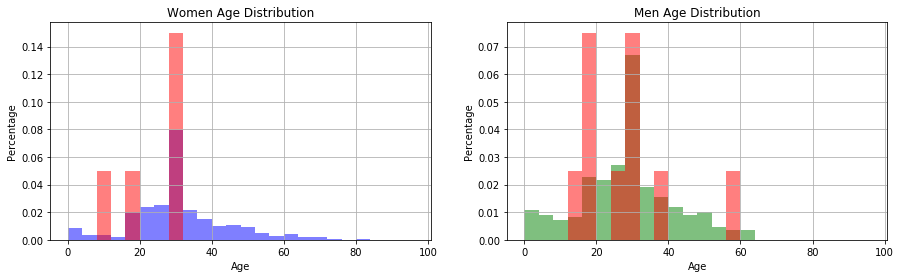

In [42]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title('Women Age Distribution')
plt.xlabel('Age')
plt.ylabel('Percentage')
unified_bins = range(0,100,4)
x_train[x_train.Sex==1.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='blue')
errs[errs.Sex==1.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='red')

plt.subplot(122)
plt.title('Men Age Distribution')
plt.xlabel('Age')
plt.ylabel('Percentage')
x_train[x_train.Sex==0.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='green')
errs[errs.Sex==0.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='red')
plt.savefig('RF_age_errors')

The *difference* in probability density is the bias of the errs

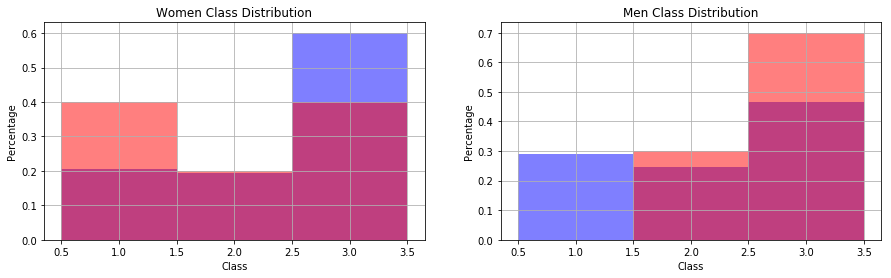

In [45]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title('Women Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage')
x_train[x_train.Sex==1.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='blue')
errs[errs.Sex==1.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='red')
plt.subplot(122)
plt.title('Men Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage')
x_train[x_train.Sex==0.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='blue')
errs[errs.Sex==0.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='red')
plt.savefig('RF_class_dist')

In [9]:
errs.Sex.value_counts()

0    12
1     4
Name: Sex, dtype: int64

In [10]:
x_train.Sex.value_counts(normalize=True)

1    0.654182
0    0.345818
Name: Sex, dtype: float64

It seems that the model is good with men in 1st class, and bad with men in 3rd class.
Inversely skewed for women, but for 4 samples, it means nothing.

In [11]:
errs.groupby(['Sex','Pclass']).size()

Sex  Pclass
0    2         3
     3         9
1    1         2
     2         1
     3         1
dtype: int64

# Let's Try ADABoost as we see that there are subsets that may benefit from more attention

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [13]:
x_tr,x_ts,y_tr,y_ts = next_split(it)

clsfr = AdaBoostClassifier()
clsfr.fit(x_tr,y_tr)
clsfr.score(x_ts,y_ts)

0.8024691358024691

### Let's tune the amount of ADABoost rounds

In [14]:
from itertools import chain

#checking different regions in different resolution
n_range = list(chain(range(2,10),range(12,20,2),range(24,50,4),range(58,300,8)))
n_average = 3

test_acc_stumps = np.zeros(len(n_range))
train_acc_stumps = np.zeros(len(n_range))

for i,n in enumerate(n_range):
    for _ in range(n_average):
        clsfr = AdaBoostClassifier(n_estimators=n)
        x_tr,x_ts,y_tr,y_ts = next_split(it)
        clsfr.fit(x_tr, y_tr)
        train_acc_stumps[i] += clsfr.score(x_tr,y_tr)/n_average
        test_acc_stumps[i] += clsfr.score(x_ts,y_ts)/n_average

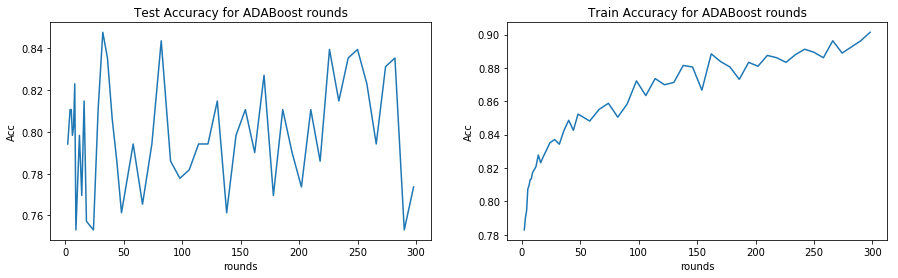

In [37]:
plt.figure(figsize=(15,4))
plt.subplot(121)    
plt.plot(n_range,test_acc_stumps)
plt.title("Test Accuracy for ADABoost rounds")
plt.xlabel('rounds')
plt.ylabel('Acc');
plt.subplot(122)    
plt.plot(n_range,train_acc_stumps)
plt.title("Train Accuracy for ADABoost rounds")
plt.xlabel('rounds')
plt.ylabel('Acc');
plt.savefig('ADA_rounds')

In [15]:
test_acc_np = np.array(test_acc_stumps)
best = np.argmax(test_acc_np, axis=None)
print(n_range[best], "rounds, in index",best, "has acc:", test_acc_np[best])

clsfr_ada_stumps = AdaBoostClassifier(n_estimators=n_range[best])
clsfr_ada_stumps.fit(x_train, y_train)
print('On validation set:', clsfr_ada_stumps.score(x_valid,y_valid))
dec_stump_desc = str(n_range[best])+'rounds, decision stumps'

32 rounds, in index 14 has acc: 0.8477366255144032
On validation set: 0.8333333333333334


### Trying a richer weak learner, Unbounded Decision Tree with leaf sample size fractional regularization

In [16]:
#checking different regions in different resolution
n_range = list(chain(range(2,10),range(12,20,2),range(24,50,4),range(58,200,8)))
leaf_size = [0.4,0.3,0.25,0.2,0.15,0.1,0.07,0.05,0.03]
n_average = 5

test_acc = np.zeros((len(leaf_size),len(n_range)))
train_acc = np.zeros((len(leaf_size),len(n_range)))
for i,l in enumerate(leaf_size):
    for j, n in enumerate(n_range):
        clsfr = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_leaf=l), n_estimators=n)
        for h in range(n_average):
            x_tr,x_ts,y_tr,y_ts = next_split(it)
            clsfr.fit(x_tr, y_tr)
            test_acc[i,j] += clsfr.score(x_ts,y_ts)/n_average
            train_acc[i,j] += clsfr.score(x_tr,y_tr)/n_average

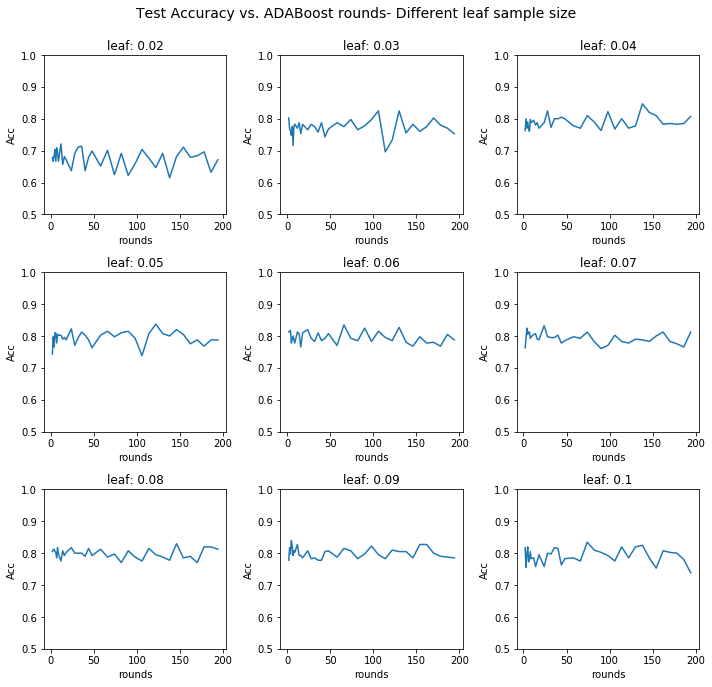

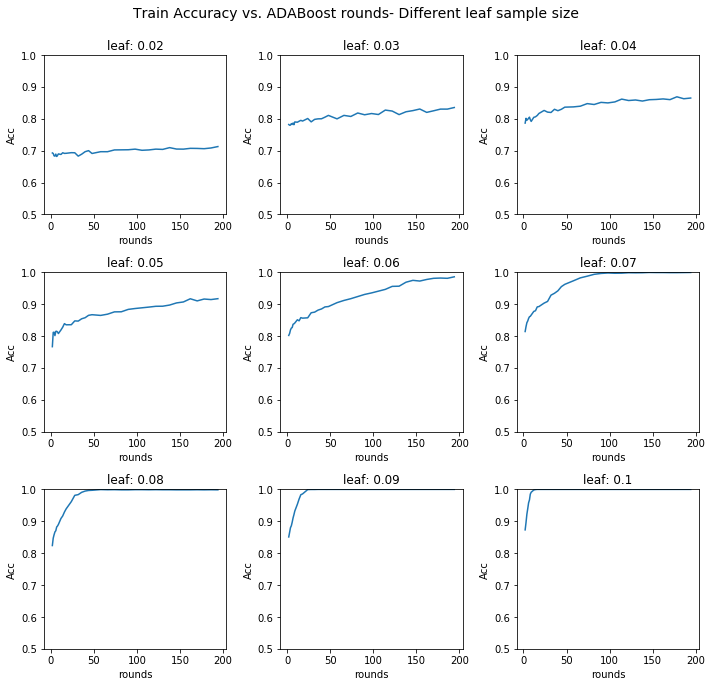

In [38]:
fig,axes = plt.subplots(3,3, figsize=(10,10))
fig.suptitle('Test Accuracy vs. ADABoost rounds- Different leaf sample size', fontsize=14)
for i in range(9):
    ax = axes[i//3][i%3]
    ax.plot(n_range,test_acc[i,:])
    ax.set_title("leaf: " + str(leaf_size[i]))
    ax.set_xlabel('rounds')
    ax.set_ylabel('Acc')
    ax.set_ylim(0.5,1.0)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig,axes = plt.subplots(3,3, figsize=(10,10))
fig.suptitle('Train Accuracy vs. ADABoost rounds- Different leaf sample size', fontsize=14)
for i in range(9):
    ax = axes[i//3][i%3]
    ax.plot(n_range,train_acc[i,:])
    ax.set_title("leaf: " + str(leaf_size[i]))
    ax.set_xlabel('rounds')
    ax.set_ylabel('Acc')
    ax.set_ylim(0.5,1.0)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]);
plt.savefig('ADA_leaf_norm')

In [18]:
test_acc_np = np.array(test_acc)
best = np.unravel_index(np.argmax(test_acc_np, axis=None), test_acc_np.shape)
print(leaf_size[best[0]], "leaf and", n_range[best[1]], "rounds, in index",best, "has acc:", test_acc_np[best])

clsfr_high_regular = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_leaf=leaf_size[best[0]]), n_estimators=n_range[best[1]])
clsfr_high_regular.fit(x_train, y_train)
print('On validation set:', clsfr_high_regular.score(x_valid,y_valid))
high_regularization_desc = "{} leaf regularization and {} rounds".format(leaf_size[best[0]],  n_range[best[1]])

0.25 leaf and 138 rounds, in index (2, 29) has acc: 0.8469135802469135
On validation set: 0.8222222222222222


When the training error is saturated, ADABoost should only degrade.. so the results are slightly weird.. I will however examine the low regularization with small number of iteration, and the best of the high regularization with higher rounds, and choose using the validation set.

### Low regularization few steps, fine grained search

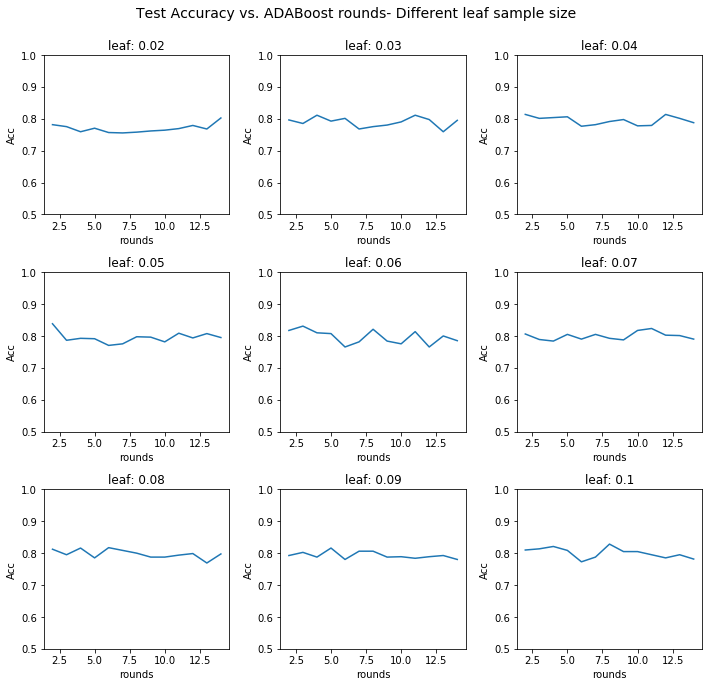

In [19]:

n_range = list(range(2,15))
leaf_size = [x/100.0 for x in range(2,11)]
n_average = 10

fig,axes = plt.subplots(3,3, figsize=(10,10))
fig.suptitle('Test Accuracy vs. ADABoost rounds- Different leaf sample size', fontsize=14)


test_acc_fine_grained = np.zeros((len(leaf_size),len(n_range)))
for i, l in enumerate(leaf_size):
    for j, n in enumerate(n_range):
        clsfr = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_leaf=l), n_estimators=n)
        for h in range(n_average):
            x_tr,x_ts,y_tr,y_ts = next_split(it)
            clsfr.fit(x_tr, y_tr)
            test_acc_fine_grained[i,j] += clsfr.score(x_ts,y_ts)/n_average
    ax = axes[i//3][i%3]
    ax.plot(n_range,test_acc_fine_grained[i,:])
    ax.set_title("leaf: " + str(l))
    ax.set_xlabel('rounds')
    ax.set_ylabel('Acc')
    ax.set_ylim(0.5,1.0)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [20]:
test_acc_np = np.array(test_acc_fine_grained)
best = np.unravel_index(np.argmax(test_acc_np, axis=None), test_acc_np.shape)
print(leaf_size[best[0]], "leaf and", n_range[best[1]], "rounds, in index",best, "has acc:", test_acc_np[best])

clsfr_low_regular = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(min_samples_leaf=leaf_size[best[0]]), n_estimators=n_range[best[1]])
clsfr_low_regular.fit(x_train, y_train)
print('On validation set:', clsfr_low_regular.score(x_valid,y_valid))
low_regularization_desc = "{} leaf regularization and {} rounds".format(leaf_size[best[0]],  n_range[best[1]])

0.05 leaf and 2 rounds, in index (3, 0) has acc: 0.8382716049382717
On validation set: 0.8333333333333334


# (Re) Reviewing errors for low regularization ADABoost

In [21]:
pred = clsfr_low_regular.predict(x_valid)
errs = x_valid[pred != y_valid]

In [22]:
errs['Survived'] = y_valid[pred != y_valid]

/home/guy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
print(y_train.value_counts(normalize=True))
errs.Survived.value_counts()

0    0.617978
1    0.382022
Name: Survived, dtype: float64


1    9
0    6
Name: Survived, dtype: int64

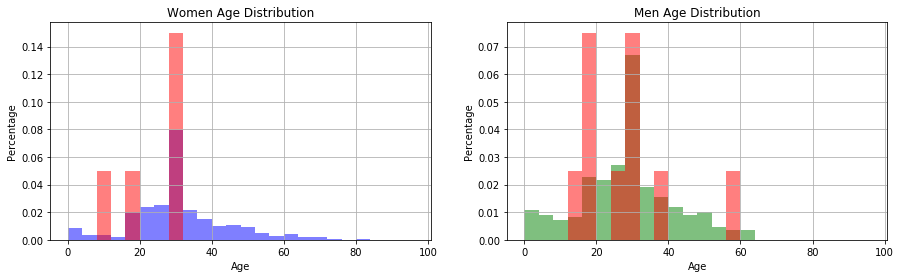

In [41]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title('Women Age Distribution')
plt.xlabel('Age')
plt.ylabel('Percentage')
unified_bins = range(0,100,4)
x_train[x_train.Sex==1.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='blue')
errs[errs.Sex==1.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='red')

plt.subplot(122)
plt.title('Men Age Distribution')
plt.xlabel('Age')
plt.ylabel('Percentage')
x_train[x_train.Sex==0.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='green')
errs[errs.Sex==0.0].Age.hist(bins=unified_bins, density=True, alpha=0.5, color='red')
plt.savefig('low_reg_ADA_age_errors')

The *difference* in probability density is the bias of the errs

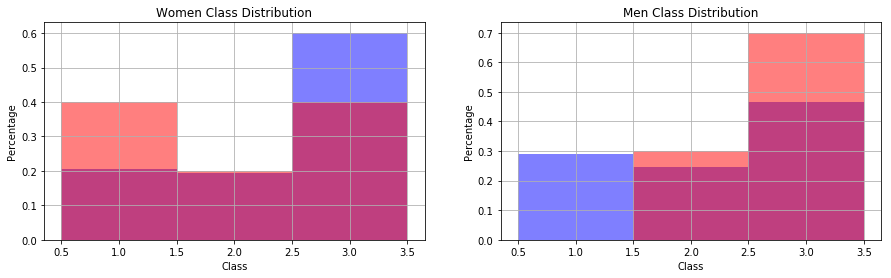

In [44]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title('Women Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage')
x_train[x_train.Sex==1.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='blue')
errs[errs.Sex==1.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='red')
plt.subplot(122)
plt.title('Men Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage')
x_train[x_train.Sex==0.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='blue')
errs[errs.Sex==0.0].Pclass.hist(bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.5, color='red')
plt.savefig('low_reg_ADA_class_dist')

In [26]:
errs.Sex.value_counts()

0    10
1     5
Name: Sex, dtype: int64

In [27]:
x_train.Sex.value_counts(normalize=True)

1    0.654182
0    0.345818
Name: Sex, dtype: float64

In [28]:
errs.groupby(['Sex','Pclass']).size()

Sex  Pclass
0    2         3
     3         7
1    1         2
     2         1
     3         2
dtype: int64

# Final results

In [32]:
print('Random forest:', rf_desc,'Accuracy:', round(clsfr_random_forest.score(x_valid, y_valid),3))
print('ADABoost:')
print(dec_stump_desc,'Accuracy:', round(clsfr_ada_stumps.score(x_valid, y_valid),3))
print(high_regularization_desc,'Accuracy:', round(clsfr_high_regular.score(x_valid, y_valid),3))
print(low_regularization_desc,'Accuracy:', round(clsfr_low_regular.score(x_valid, y_valid),3))


Random forest: 63 trees Accuracy: 0.822
ADABoost:
32rounds, decision stumps Accuracy: 0.833
0.25 leaf regularization and 138 rounds Accuracy: 0.822
0.05 leaf regularization and 2 rounds Accuracy: 0.833


As the training set is quite small, the difference in accuracy is due to +-1 error, and probably doesn't mean anything, hence they are all equally good